In [1]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [2]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [4]:
def gradient_penalty(critic, real, fake, device="cpu"):
    #Interpolate between real and fake samples
    #Randomly pick a point between real data (real) and generated data (fake).
    #These are the samples (x)used to check the Lipschitz constraint
    #requires_grad_(True) allows PyTorch to compute gradients w.r.t. these inputs.
    
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    #Pass interpolated samples through the critic
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    #Compute gradients of critic outputs w.r.t. inputs
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    #Flatten and compute L2 norm of gradients
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.37MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.33MB/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [0/100] Batch 0/938 Loss D: 19.5632, Loss G: 0.3156


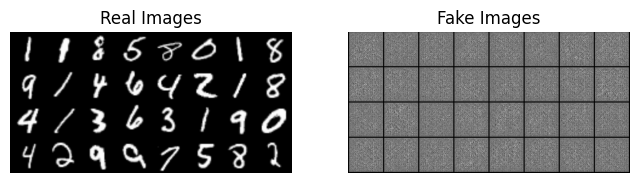

 21%|██▏       | 200/938 [00:30<01:43,  7.14it/s]

Epoch [0/100] Batch 200/938 Loss D: -104.2146, Loss G: 83.4963


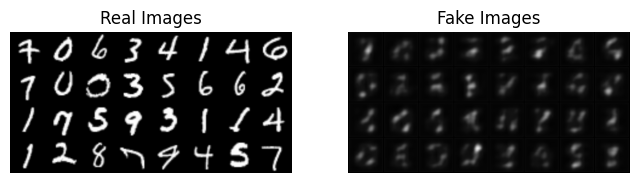

 43%|████▎     | 400/938 [00:58<01:18,  6.85it/s]

Epoch [0/100] Batch 400/938 Loss D: -89.1607, Loss G: 89.5079


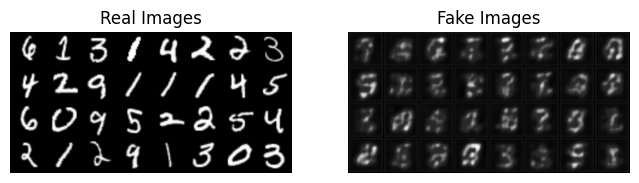

 64%|██████▍   | 600/938 [01:28<00:50,  6.68it/s]

Epoch [0/100] Batch 600/938 Loss D: -70.1630, Loss G: 76.4890


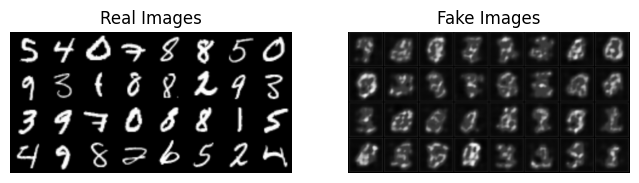

 85%|████████▌ | 800/938 [01:58<00:19,  6.93it/s]

Epoch [0/100] Batch 800/938 Loss D: -54.8186, Loss G: 76.4680


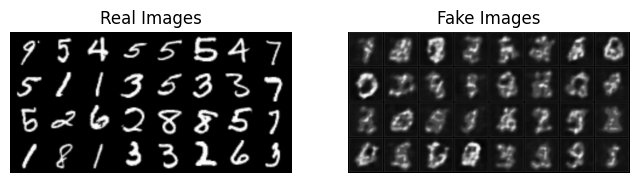

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/100] Batch 0/938 Loss D: -43.0191, Loss G: 69.9702


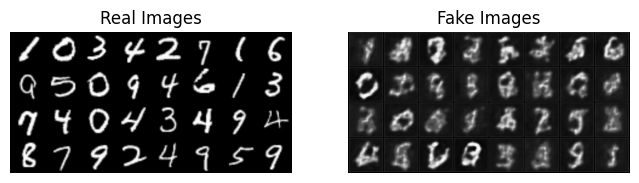

 21%|██▏       | 200/938 [00:29<01:47,  6.88it/s]

Epoch [1/100] Batch 200/938 Loss D: -26.9079, Loss G: 64.9626


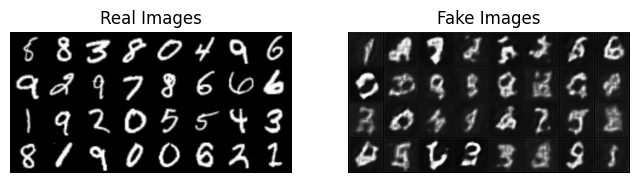

 43%|████▎     | 400/938 [00:58<01:18,  6.84it/s]

Epoch [1/100] Batch 400/938 Loss D: -18.3980, Loss G: 65.3925


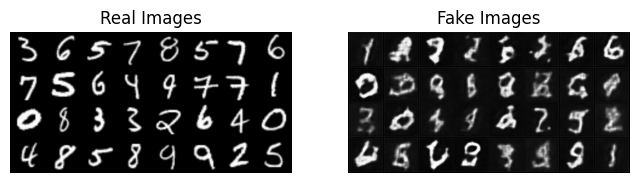

 64%|██████▍   | 600/938 [01:27<00:49,  6.87it/s]

Epoch [1/100] Batch 600/938 Loss D: -14.3851, Loss G: 62.1723


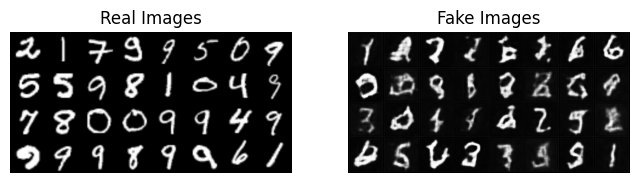

 85%|████████▌ | 800/938 [01:57<00:19,  6.90it/s]

Epoch [1/100] Batch 800/938 Loss D: -11.5729, Loss G: 61.0309


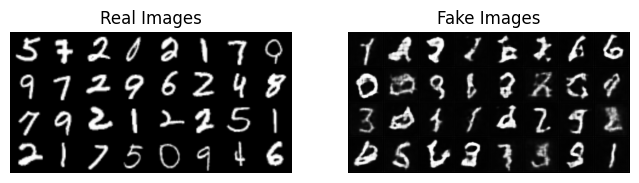

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/100] Batch 0/938 Loss D: -9.2098, Loss G: 58.9201


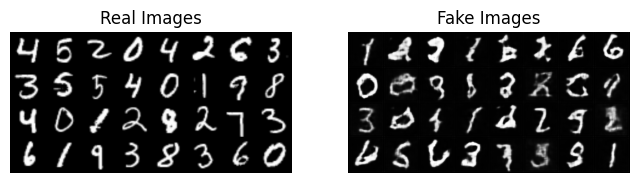

 21%|██▏       | 200/938 [00:29<01:46,  6.92it/s]

Epoch [2/100] Batch 200/938 Loss D: -11.0782, Loss G: 58.1689


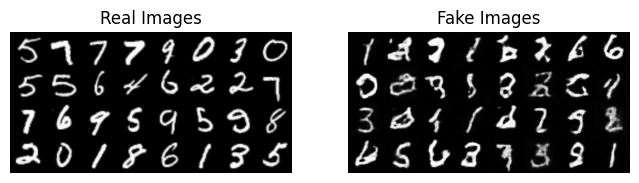

 43%|████▎     | 400/938 [00:58<01:18,  6.83it/s]

Epoch [2/100] Batch 400/938 Loss D: -8.3363, Loss G: 58.7444


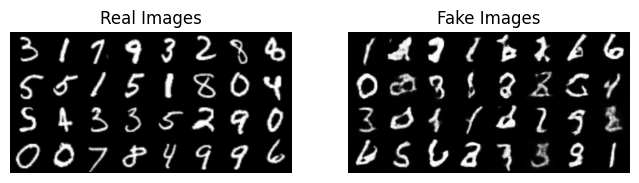

 64%|██████▍   | 600/938 [01:27<00:48,  6.92it/s]

Epoch [2/100] Batch 600/938 Loss D: -12.1131, Loss G: 66.1480


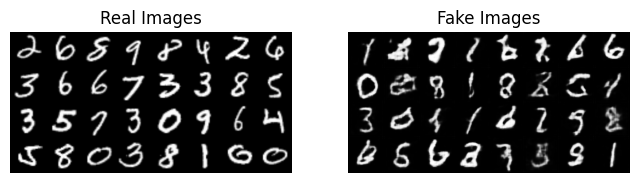

 85%|████████▌ | 800/938 [01:57<00:20,  6.87it/s]

Epoch [2/100] Batch 800/938 Loss D: -8.2494, Loss G: 66.2987


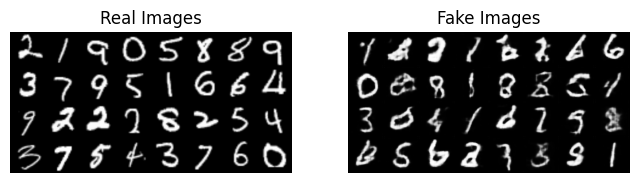

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/100] Batch 0/938 Loss D: -9.1832, Loss G: 66.6632


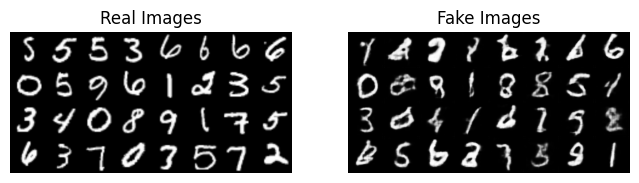

 21%|██▏       | 200/938 [00:29<01:47,  6.88it/s]

Epoch [3/100] Batch 200/938 Loss D: -7.8387, Loss G: 67.0568


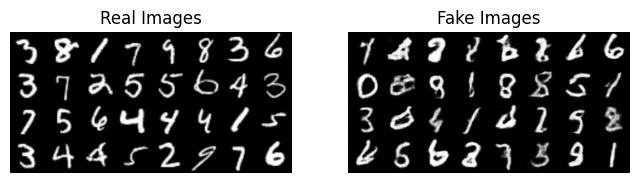

 43%|████▎     | 400/938 [00:58<01:17,  6.94it/s]

Epoch [3/100] Batch 400/938 Loss D: -8.6139, Loss G: 65.8938


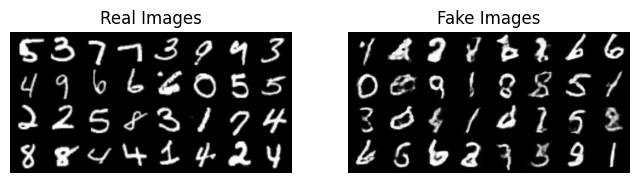

 64%|██████▍   | 600/938 [01:27<00:49,  6.86it/s]

Epoch [3/100] Batch 600/938 Loss D: -7.0145, Loss G: 64.9972


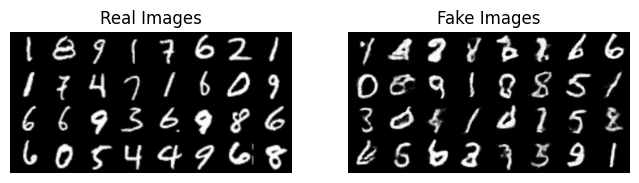

 85%|████████▌ | 800/938 [01:56<00:20,  6.83it/s]

Epoch [3/100] Batch 800/938 Loss D: -6.7824, Loss G: 68.7151


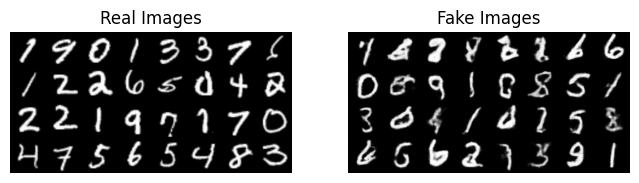

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/100] Batch 0/938 Loss D: -9.9497, Loss G: 72.4684


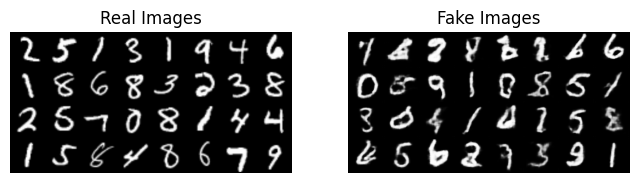

  4%|▎         | 35/938 [00:05<02:11,  6.86it/s]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

# Transform
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# Dataset (MNIST)
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
# For CelebA, uncomment:
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transform)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Models
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# Fixed noise for monitoring progress
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Show results occasionally
        if batch_idx % 200 == 0:  # adjust frequency
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)

                # Make grids
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                # Plot with matplotlib
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(img_grid_real.permute(1, 2, 0).cpu().numpy())
                axs[0].set_title("Real Images")
                axs[0].axis("off")

                axs[1].imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
                axs[1].set_title("Fake Images")
                axs[1].axis("off")

                plt.show()
